## Sequence 2 sequence model for predicting the next block accesses in IO traces

We use traces from microsoft cambridge http://iotta.snia.org/traces/block-io/388
Download MSR Cambridge Traces 2

##### I/O trace file format

The files are gzipped csv (comma-separated text) files. The fields in
the csv are:

Timestamp,Hostname,DiskNumber,Type,Offset,Size,ResponseTime

In [ ]:
!pip install pandas

In [19]:
import numpy as np
import pandas as pd
import glob
import csv
import sys
import os

In [15]:
names = ['TimeStamp','Host_Name','DiskNumber','Operation_Type','ByteOffset','IOSize','Response_Time']
path = "traces"
all_files = glob.glob(os.path.join(path, "*.csv"))
print(all_files)

['traces/msr-cambridge2-sample.csv']


#### Read the trace file

In [517]:
df = pd.read_csv(all_files[0],engine='python',skiprows =1,header=None,na_values=['-1'], index_col=False) 
names = ['TimeStamp','Host_Name','DiskNumber','Operation_Type','ByteOffset','IOSize','Response_Time']
df.columns = names

In [519]:
#sort by timestamp and drop the index
df = df.sort_values(by=['TimeStamp'])
df.reset_index(inplace=True, drop=True)
print("Number of records in the sample file = {}".format(len(df)))

Number of records in the sample file = 999


In [520]:
df.head()

,TimeStamp,Host_Name,DiskNumber,Operation_Type,ByteOffset,IOSize,Response_Time
0,128166372016382155,rsrch,0,Write,1317441536,8192,1963
1,128166372026382245,rsrch,0,Write,2436440064,4096,1835
2,128166372036348580,rsrch,0,Write,3196526592,57344,35436
3,128166372036379390,rsrch,0,Write,3154132992,4096,4626
4,128166372036382264,rsrch,0,Write,3154124800,4096,1752


ByteOffset is the field of interest, the application will access specifc offsets, some of them repeatedly, which is the pattern we essentialy want to predict. We will find the unique byte offsets that are in use in the trace. We will index these unique byte offsets into a dictionary where the key is the offset while the value if the frequency of the access of that offset.

In [521]:
address_map = dict(Counter(df['ByteOffset']))
sorted_address_map = sorted(dict(address_map).items(), key=operator.itemgetter(1))

In [522]:
#the byte offset and the number of times it was accessed, sorted by acess count
print(sorted_address_map[:5])
print(sorted_address_map[-5:])

[(1317441536, 1), (2436440064, 1), (3196526592, 1), (7609925632, 1), (7612473344, 1)]
[(7478116352, 10), (3154124800, 11), (8587796480, 15), (3154137088, 53), (3154132992, 54)]


In [524]:
print("There are {} unique offsets in the trace.".format(len(sorted_address_map)))

There are 607 unique offsets in the trace.


The number of times the offset was accessed is relevant only to model training but irrelevant to feature definition. So during feature definition, we will only work with the offset ids and build a vocab using those.

- offset 1 --> 1
- offset 10 --> 2

The offsets will map to unique integers ordered by their frequency of access.

In [525]:
address_remap = {}
count = 0
while(count<len(sorted_address_map)):
#     if(count < 1000):
    address_remap[count] = sorted_address_map[len(sorted_address_map)-count - 1][0]
#     else:
#         address_remap[1001] = sorted_address_map[len(sorted_address_map)-count - 1][0]
    count = count + 1

Each unique offset is stored only once in address remap and the key is the positional index in the sorted access table, sorted by access count, the frequency of access is only preserved in the index/key of the address remap table, the value being the block.

In [527]:
address_remap

{0: 3154132992,
 1: 3154137088,
 2: 8587796480,
 3: 3154124800,
 4: 7478116352,
 5: 3154128896,
 6: 7852126208,
 7: 7818776576,
 8: 7818829824,
 9: 14759608320,
 10: 15123931136,
 11: 15645843456,
 12: 1278550016,
 13: 6216929280,
 14: 14068207616,
 15: 8724254720,
 16: 3302887424,
 17: 3228045312,
 18: 3299819520,
 19: 15590514688,
 20: 7478132736,
 21: 7478128640,
 22: 7478124544,
 23: 7478116864,
 24: 2500763648,
 25: 8979197952,
 26: 2022240256,
 27: 3057287168,
 28: 15590518784,
 29: 13200945152,
 30: 7478136832,
 31: 2129981440,
 32: 596987904,
 33: 1705521152,
 34: 13200961536,
 35: 17827762176,
 36: 621047808,
 37: 17674240,
 38: 131674112,
 39: 4382728192,
 40: 8598085632,
 41: 8588992512,
 42: 8597577728,
 43: 7774507008,
 44: 3221348352,
 45: 15282630656,
 46: 1705496576,
 47: 3276435456,
 48: 1412071424,
 49: 1317449728,
 50: 7615483904,
 51: 11395518464,
 52: 7615655936,
 53: 11395559424,
 54: 8762142720,
 55: 11395534848,
 56: 7295303680,
 57: 3267555328,
 58: 11359895552

In [528]:
rev_address_remap = {y:x for x,y in address_remap.items()}

Reverse the order in address remap, the key is the offset and the value is the positional index in the sorted access frequency table, so that we now have a dictionary where key is the offset and the value is the index into the sorted offset frequency table

e.g. 3154132992 is most accessed (33 times) in the trace and its index is 0, followed by 3154137088 (accessed 32 times) with index = 1

In [532]:
rev_address_remap

{3154132992: 0,
 3154137088: 1,
 8587796480: 2,
 3154124800: 3,
 7478116352: 4,
 3154128896: 5,
 7852126208: 6,
 7818776576: 7,
 7818829824: 8,
 14759608320: 9,
 15123931136: 10,
 15645843456: 11,
 1278550016: 12,
 6216929280: 13,
 14068207616: 14,
 8724254720: 15,
 3302887424: 16,
 3228045312: 17,
 3299819520: 18,
 15590514688: 19,
 7478132736: 20,
 7478128640: 21,
 7478124544: 22,
 7478116864: 23,
 2500763648: 24,
 8979197952: 25,
 2022240256: 26,
 3057287168: 27,
 15590518784: 28,
 13200945152: 29,
 7478136832: 30,
 2129981440: 31,
 596987904: 32,
 1705521152: 33,
 13200961536: 34,
 17827762176: 35,
 621047808: 36,
 17674240: 37,
 131674112: 38,
 4382728192: 39,
 8598085632: 40,
 8588992512: 41,
 8597577728: 42,
 7774507008: 43,
 3221348352: 44,
 15282630656: 45,
 1705496576: 46,
 3276435456: 47,
 1412071424: 48,
 1317449728: 49,
 7615483904: 50,
 11395518464: 51,
 7615655936: 52,
 11395559424: 53,
 8762142720: 54,
 11395534848: 55,
 7295303680: 56,
 3267555328: 57,
 11359895552: 58

The index of the offset in the address map table now becomes the identiying token of the offset in the input data. We will create an 'offset class' using this token. i.e. if the byte offset for an input record is 3154132992, the offset class will be 0 (from the address map table)

In [534]:
# use the position of the byteoffset value in the address map, that becomes the class or token we use going forwards and not the actual byte offste value
# create a new field called byte offset the value of which indicates the index in the 
# sorted byte offset frequency table, lower index indicates higher access frequency
count = 0
label_list = []
rogue_delta = []
label =0.0
while (count < len(df)):
    x = df['ByteOffset'].iloc[count]
    if x in rev_address_remap:
        label = rev_address_remap[x]
        label_list.append(label)
    else:
        label_list.append(1001)
        rogue_delta.append(x)
    count = count+1

df['ByteOffset_class']  = label_list
print(len(Counter(df['ByteOffset_class'])))
print(len(rogue_delta))
#we won't have rouge delta since we did not take top 1000, we took all of them

607
0


#### Split the data into train and test

In [536]:
import math
training_pt_1 = math.floor((len(df)*0.75)) 
data_train = df['ByteOffset_class'][:training_pt_1]
data_test = df['ByteOffset_class'][training_pt_1+1:]
print(len(data_train))
print(len(data_test))

749
249


The data in the training dataset is the index of the offset in the sorted offset frequency table. Same for test.

In [538]:
data_train[:5]

0    606
1    605
2    604
3      0
4      3
Name: ByteOffset_class, dtype: int64

We have now pre-processed our dataset which has indexes of the offsets in a sorted offset frequency table instead of the large offset id itself. The value therefore carries some information about the offset itself, i.e. the likelyhood of the offset appearing is also encoded in this number since the number is from the sorted frequency table. We will now perform the vectorization of this value. As ususal, we will need to build a vocabulary and then tokenize the values.
For tokenization, we find the unique ids and create a dictionary, and use the index in the dictionary as the corresponding token for the value.

In [544]:
count_pairs

[(0, 33),
 (1, 32),
 (2, 6),
 (6, 6),
 (7, 6),
 (8, 6),
 (12, 6),
 (15, 6),
 (19, 5),
 (3, 4),
 (4, 4),
 (5, 4),
 (9, 4),
 (10, 4),
 (11, 4),
 (13, 4),
 (18, 4),
 (28, 4),
 (31, 4),
 (32, 4),
 (33, 4),
 (34, 4),
 (35, 4),
 (14, 3),
 (16, 3),
 (17, 3),
 (36, 3),
 (37, 3),
 (38, 3),
 (39, 3),
 (43, 3),
 (44, 3),
 (45, 3),
 (20, 2),
 (21, 2),
 (22, 2),
 (23, 2),
 (27, 2),
 (29, 2),
 (30, 2),
 (58, 2),
 (59, 2),
 (60, 2),
 (61, 2),
 (62, 2),
 (63, 2),
 (64, 2),
 (65, 2),
 (66, 2),
 (67, 2),
 (68, 2),
 (69, 2),
 (70, 2),
 (71, 2),
 (72, 2),
 (73, 2),
 (74, 2),
 (75, 2),
 (76, 2),
 (77, 2),
 (78, 2),
 (79, 2),
 (80, 2),
 (84, 2),
 (87, 2),
 (88, 2),
 (89, 2),
 (90, 2),
 (91, 2),
 (92, 2),
 (93, 2),
 (94, 2),
 (95, 2),
 (96, 2),
 (97, 2),
 (98, 2),
 (99, 2),
 (100, 2),
 (101, 2),
 (103, 2),
 (104, 2),
 (105, 2),
 (106, 2),
 (107, 2),
 (108, 2),
 (109, 2),
 (110, 2),
 (111, 2),
 (112, 2),
 (113, 2),
 (114, 2),
 (115, 2),
 (116, 2),
 (117, 2),
 (119, 2),
 (120, 2),
 (121, 2),
 (122, 2),
 (123, 

In [540]:
counter = collections.Counter(data_train)
count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
words, _ = list(zip(*count_pairs))
word_to_id = dict(zip(words, range(len(words))))
word_to_id

{0: 0,
 1: 1,
 2: 2,
 6: 3,
 7: 4,
 8: 5,
 12: 6,
 15: 7,
 19: 8,
 3: 9,
 4: 10,
 5: 11,
 9: 12,
 10: 13,
 11: 14,
 13: 15,
 18: 16,
 28: 17,
 31: 18,
 32: 19,
 33: 20,
 34: 21,
 35: 22,
 14: 23,
 16: 24,
 17: 25,
 36: 26,
 37: 27,
 38: 28,
 39: 29,
 43: 30,
 44: 31,
 45: 32,
 20: 33,
 21: 34,
 22: 35,
 23: 36,
 27: 37,
 29: 38,
 30: 39,
 58: 40,
 59: 41,
 60: 42,
 61: 43,
 62: 44,
 63: 45,
 64: 46,
 65: 47,
 66: 48,
 67: 49,
 68: 50,
 69: 51,
 70: 52,
 71: 53,
 72: 54,
 73: 55,
 74: 56,
 75: 57,
 76: 58,
 77: 59,
 78: 60,
 79: 61,
 80: 62,
 84: 63,
 87: 64,
 88: 65,
 89: 66,
 90: 67,
 91: 68,
 92: 69,
 93: 70,
 94: 71,
 95: 72,
 96: 73,
 97: 74,
 98: 75,
 99: 76,
 100: 77,
 101: 78,
 103: 79,
 104: 80,
 105: 81,
 106: 82,
 107: 83,
 108: 84,
 109: 85,
 110: 86,
 111: 87,
 112: 88,
 113: 89,
 114: 90,
 115: 91,
 116: 92,
 117: 93,
 119: 94,
 120: 95,
 121: 96,
 122: 97,
 123: 98,
 124: 99,
 125: 100,
 127: 101,
 40: 102,
 41: 103,
 42: 104,
 57: 105,
 81: 106,
 82: 107,
 83: 108,
 85: 

In [130]:
print(count_pairs[:5])
print(count_pairs[-1])
#which positional value occurs how many time in the data, e.g. the positional value 0, 

[(0, 33), (1, 32), (2, 6), (6, 6), (7, 6)]
(606, 1)


The word_to_id is going to be the lookup dictionary for us to index into for each offset index to get the corresponding token from the vocabulary table.

In [545]:
print("All are unique in the words list...")
print(len(words))
print(len(np.unique(words)))

All are unique in the words list...
521
521


In [551]:
import collections
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
import numpy as np
import argparse


def build_vocab(train_data):
    counter = collections.Counter(train_data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    return word_to_id


def data_to_word_ids(data, word_to_id):
    return [word_to_id[word] for word in data if word in word_to_id]


def load_data():
    # build the complete vocabulary, then convert data to list of integers
    word_to_id = build_vocab(data_train)
    train_data = data_to_word_ids(data_train, word_to_id)
    test_data = data_to_word_ids(data_test, word_to_id)
    vocab_size = len(word_to_id)
    reversed_dictionary = dict(zip(word_to_id.values(), word_to_id.keys()))
    return train_data, test_data, vocab_size, reversed_dictionary

In [552]:
train_data, test_data, vocab_size, reversed_dictionary = load_data()

In [549]:
train_data[:5]

[520, 519, 518, 0, 9]

In [550]:
# mnist = keras.datasets.mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [556]:
def gen_data(data, look_back):   
    for i in range(len(data)):
        x = data[i: i+look_back]
        y = data[i + 1: i+look_back+1]
        if (len(y) == look_back):
            yield x, to_categorical(y, num_classes=vocab_size)

def get_dataset(data, look_back=30): 
    generator = lambda: gen_data(data, look_back)
    dataset = tf.data.Dataset.from_generator(
         generator,
         output_signature=(
             tf.TensorSpec(shape=(look_back), dtype=tf.int32),
             tf.TensorSpec(shape=(look_back, vocab_size), dtype=tf.int32)))
    return dataset

In [557]:
batch_size = 32
look_back = 32
ds_train = get_dataset(train_data, look_back)
ds_test = get_dataset(test_data, look_back)
dataset_train = ds_train.batch(batch_size, drop_remainder=True)
dataset_test = ds_test.batch(batch_size, drop_remainder=True)

In [558]:
dataset_train.element_spec

(TensorSpec(shape=(32, 32), dtype=tf.int32, name=None),
 TensorSpec(shape=(32, 32, 521), dtype=tf.int32, name=None))

In [559]:
dataset_test.element_spec

(TensorSpec(shape=(32, 32), dtype=tf.int32, name=None),
 TensorSpec(shape=(32, 32, 521), dtype=tf.int32, name=None))

In [561]:
for a,b in dataset_train.take(3):
    print(b.shape)

(32, 32, 521)
(32, 32, 521)
(32, 32, 521)


### build a seq to seq model

In [562]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [566]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [567]:
learning_rate = CustomSchedule(128)

In [570]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(128, return_sequences=True))
model.add(TimeDistributed(Dense(vocabulary)))
# Add a Dense layer with 10 units.
model.add(Activation('softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
lstm_24 (LSTM)               (None, None, 128)         98816     
_________________________________________________________________
lstm_25 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, None, 521)         67209     
_________________________________________________________________
module_wrapper_19 (ModuleWra (None, None, 521)         0         
Total params: 361,609
Trainable params: 361,609
Non-trainable params: 0
_________________________________________________________________


In [571]:
history = model.fit(
    dataset_train, validation_data=dataset_test, epochs=100
)

Epoch 1/100
22/22 [==============================] - 3s 48ms/step - loss: 6.2558 - accuracy: 9.3217e-04 - val_loss: 6.2557 - val_accuracy: 3.2552e-04
Epoch 2/100
22/22 [==============================] - 0s 22ms/step - loss: 6.2557 - accuracy: 0.0011 - val_loss: 6.2553 - val_accuracy: 0.0020
Epoch 3/100
22/22 [==============================] - 0s 21ms/step - loss: 6.2555 - accuracy: 0.0047 - val_loss: 6.2548 - val_accuracy: 0.0225
Epoch 4/100
22/22 [==============================] - 0s 21ms/step - loss: 6.2552 - accuracy: 0.0192 - val_loss: 6.2540 - val_accuracy: 0.0889
Epoch 5/100
22/22 [==============================] - 0s 21ms/step - loss: 6.2548 - accuracy: 0.0388 - val_loss: 6.2529 - val_accuracy: 0.1484
Epoch 6/100
22/22 [==============================] - 0s 21ms/step - loss: 6.2543 - accuracy: 0.0455 - val_loss: 6.2514 - val_accuracy: 0.1501
Epoch 7/100
22/22 [==============================] - 0s 21ms/step - loss: 6.2535 - accuracy: 0.0451 - val_loss: 6.2491 - val_accuracy: 0.151

In [514]:
model.predict(dataset_test)

array([[[0.00212598, 0.00212382, 0.00194888, ..., 0.00190843,
         0.00190759, 0.00191215],
        [0.0021422 , 0.00213938, 0.00195065, ..., 0.0019071 ,
         0.00190439, 0.00191194],
        [0.0021562 , 0.00215166, 0.00195161, ..., 0.00190729,
         0.00190096, 0.0019114 ],
        ...,
        [0.0022037 , 0.00221859, 0.00195887, ..., 0.00190693,
         0.00189011, 0.00190544],
        [0.00220353, 0.00221898, 0.00195878, ..., 0.00190687,
         0.00189065, 0.00190489],
        [0.00220298, 0.00221942, 0.00195914, ..., 0.00190793,
         0.00189081, 0.00190401]],

       [[0.00212426, 0.00212445, 0.0019491 , ..., 0.00190885,
         0.00190892, 0.0019109 ],
        [0.00214083, 0.00213909, 0.0019502 , ..., 0.00190799,
         0.00190574, 0.0019105 ],
        [0.00215425, 0.00215187, 0.00195066, ..., 0.00190687,
         0.00190395, 0.00191005],
        ...,
        [0.00220355, 0.00221883, 0.00195872, ..., 0.00190687,
         0.00189065, 0.00190491],
        [0.0

In [572]:
history.history

{'loss': [6.255770683288574,
  6.255681991577148,
  6.255500793457031,
  6.255212306976318,
  6.254806041717529,
  6.2542572021484375,
  6.253503322601318,
  6.252418041229248,
  6.250692844390869,
  6.2474284172058105,
  6.239109516143799,
  6.208113193511963,
  6.140500068664551,
  6.092613220214844,
  6.064203262329102,
  6.042370796203613,
  6.022099018096924,
  6.00004768371582,
  5.971428394317627,
  5.936738967895508,
  5.903785705566406,
  5.8719635009765625,
  5.839128017425537,
  5.80436897277832,
  5.772350788116455,
  5.736111640930176,
  5.700929641723633,
  5.663263320922852,
  5.63111686706543,
  5.599522113800049,
  5.569137096405029,
  5.54015588760376,
  5.515081405639648,
  5.483862400054932,
  5.458612442016602,
  5.4295759201049805,
  5.403482437133789,
  5.365302562713623,
  5.34087610244751,
  5.312288284301758,
  5.308352947235107,
  5.271923542022705,
  5.236949443817139,
  5.224453449249268,
  5.184234142303467,
  5.1753153800964355,
  5.15186071395874,
  5.13

In [574]:
!pip install matplotlib

     |████████████████████████████████| 10.3 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 55.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 71.7 MB/s eta 0:00:01


In [575]:
import matplotlib.pyplot as plt
%matplotlib inline

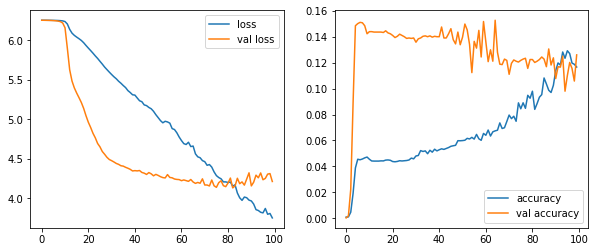

In [584]:
f, a = plt.subplots(1,2, figsize=(10,4))
x = np.arange(len(history.history['loss']))
a[0].plot(history.history['loss'], label='loss')
a[0].plot(history.history['val_loss'], label='val loss')
a[0].legend()

a[1].plot(history.history['accuracy'], label='accuracy')
a[1].plot(history.history['val_accuracy'], label='val accuracy')
a[1].legend()

## Not used

In [232]:
import collections
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
#from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
import argparse

In [233]:
class KerasBatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
                # convert all of temp_y into a one hot representation
                y[i, :, :] = to_categorical(temp_y, num_classes=self.vocabulary)
                self.current_idx += self.skip_step
            yield x, y

In [277]:
a

array([[  1.,   9.,  14., ...,   1.,  11.,   0.],
       [  9.,  14.,  14., ...,   9.,   2., 103.],
       [  1.,   9.,  14., ...,   1.,  11.,   0.],
       ...,
       [  9.,  14.,  14., ...,   9.,   2., 103.],
       [  1.,   9.,  14., ...,   1.,  11.,   0.],
       [  9.,  14.,  14., ...,   9.,   2., 103.]])

In [505]:
vocab_size = 521
def gen_data(data, look_back):   
    for i in range(len(data)):
        x = data[i: i+look_back]
        #if (len(x) == look_back):
        y = data[i + 1: i+look_back+1]
        if (len(y) == look_back):
            yield x, to_categorical(y, num_classes=vocab_size)
#   ragged_tensor = tf.ragged.constant([[1, 2], [3]])
#   yield 42, ragged_tensor

def get_dataset(data, look_back=30): 
    generator = lambda: gen_data(data, look_back)
    dataset = tf.data.Dataset.from_generator(
         generator,
         output_signature=(
             tf.TensorSpec(shape=(look_back), dtype=tf.int32),
             tf.TensorSpec(shape=(look_back, 521), dtype=tf.int32)))
    return dataset

In [506]:
train_data[1:10]

[519, 518, 0, 9, 517, 32, 516, 32, 515]

In [481]:
len(train_data)

749

In [482]:
len(test_data)

144

In [507]:
ds_train = get_dataset(train_data)

In [508]:
ds_test = get_dataset(test_data)

In [485]:
for d in ds_train.take(3):
    print(d)

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([520, 519, 518,   0,   9, 517,  32, 516,  32, 515], dtype=int32)>, <tf.Tensor: shape=(10, 521), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>)
(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([519, 518,   0,   9, 517,  32, 516,  32, 515, 101], dtype=int32)>, <tf.Tensor: shape=(10, 521), dtype=int32, numpy=
array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>)
(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([518,   0,   9, 517,  32, 516,  32, 515, 101,  16], dtype=int32)>, <tf.Tensor: shape=(10, 521), dtype=int32, numpy=
array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0,

In [510]:
dataset_train = ds_train.batch(32, drop_remainder=True)
dataset_test = ds_test.batch(32, drop_remainder=True)

In [511]:
dataset_train.element_spec

(TensorSpec(shape=(32, 30), dtype=tf.int32, name=None),
 TensorSpec(shape=(32, 30, 521), dtype=tf.int32, name=None))

In [488]:
for x in dataset_train.take(20):
    print(len(x))

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [490]:
for x in dataset_test.take(10):
    print(len(x))

2
2
2
2


In [234]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
# from sklearn.metrics import confusion_matrix
# from sklearn import metrics
from functools import reduce
import pickle
import tarfile
import numpy as np
import re
import os
import time
import keras
from keras.callbacks import ModelCheckpoint

In [271]:
for a, b in test_data_generator.generate():
    print(a)

[[  1.   9.  14. ...   1.  11.   0.]
 [  9.  14.  14. ...   9.   2. 103.]
 [  1.   9.  14. ...   1.  11.   0.]
 ...
 [  9.  14.  14. ...   9.   2. 103.]
 [  1.   9.  14. ...   1.  11.   0.]
 [  9.  14.  14. ...   9.   2. 103.]]
[[  1.   9.  14. ...   1.  11.   0.]
 [  9.  14.  14. ...   9.   2. 103.]
 [  1.   9.  14. ...   1.  11.   0.]
 ...
 [  9.  14.  14. ...   9.   2. 103.]
 [  1.   9.  14. ...   1.  11.   0.]
 [  9.  14.  14. ...   9.   2. 103.]]
[[  1.   9.  14. ...   1.  11.   0.]
 [  9.  14.  14. ...   9.   2. 103.]
 [  1.   9.  14. ...   1.  11.   0.]
 ...
 [  9.  14.  14. ...   9.   2. 103.]
 [  1.   9.  14. ...   1.  11.   0.]
 [  9.  14.  14. ...   9.   2. 103.]]
[[  1.   9.  14. ...   1.  11.   0.]
 [  9.  14.  14. ...   9.   2. 103.]
 [  1.   9.  14. ...   1.  11.   0.]
 ...
 [  9.  14.  14. ...   9.   2. 103.]
 [  1.   9.  14. ...   1.  11.   0.]
 [  9.  14.  14. ...   9.   2. 103.]]
[[  1.   9.  14. ...   1.  11.   0.]
 [  9.  14.  14. ...   9.   2. 103.]
 [  1.   9.  1

KeyboardInterrupt: 

In [272]:
a

array([[  1.,   9.,  14., ...,   1.,  11.,   0.],
       [  9.,  14.,  14., ...,   9.,   2., 103.],
       [  1.,   9.,  14., ...,   1.,  11.,   0.],
       ...,
       [  9.,  14.,  14., ...,   9.,   2., 103.],
       [  1.,   9.,  14., ...,   1.,  11.,   0.],
       [  9.,  14.,  14., ...,   9.,   2., 103.]])

In [273]:
b

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [244]:
test_data

[1,
 9,
 14,
 13,
 14,
 13,
 12,
 23,
 12,
 0,
 23,
 1,
 0,
 1,
 0,
 11,
 5,
 5,
 4,
 37,
 4,
 3,
 37,
 3,
 0,
 1,
 1,
 111,
 0,
 9,
 103,
 102,
 2,
 104,
 2,
 10,
 0,
 1,
 2,
 36,
 107,
 0,
 108,
 106,
 10,
 1,
 35,
 33,
 34,
 39,
 15,
 1,
 11,
 25,
 16,
 24,
 113,
 0,
 9,
 112,
 6,
 1,
 11,
 0,
 9,
 14,
 14,
 13,
 0,
 13,
 38,
 38,
 1,
 12,
 12,
 0,
 1,
 1,
 11,
 15,
 105,
 25,
 0,
 9,
 1,
 11,
 10,
 109,
 2,
 2,
 110,
 35,
 0,
 36,
 0,
 33,
 9,
 10,
 34,
 2,
 1,
 1,
 0,
 24,
 5,
 5,
 4,
 4,
 23,
 3,
 3,
 0,
 23,
 1,
 1,
 0,
 1,
 11,
 0,
 16,
 15,
 6,
 25,
 24,
 1,
 9,
 2,
 103,
 104,
 1,
 102,
 2,
 2,
 10,
 36,
 35,
 0,
 0,
 1,
 34,
 33,
 39,
 10,
 0]

In [242]:
from keras.callbacks import EarlyStopping
look_back = 64
num_steps = look_back
batch_size = 64

train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, vocabulary, skip_step=num_steps) 
#valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocabulary, skip_step=num_steps)
test_data_generator = KerasBatchGenerator(test_data, num_steps, batch_size, vocabulary, skip_step=num_steps)

hidden_size = 1500
use_dropout=True 

model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
if use_dropout:
    model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))


#optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',keras.metrics.Precision(), keras.metrics.Recall()])

print(model.summary())
monitor = EarlyStopping(monitor='val_categorical_accuracy', min_delta=1e-3, patience=7, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='./model-trained.hdf5', verbose=1)
num_epochs = 5000

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 64, 1500)          781500    
_________________________________________________________________
lstm_14 (LSTM)               (None, 64, 1500)          18006000  
_________________________________________________________________
lstm_15 (LSTM)               (None, 64, 1500)          18006000  
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 1500)          0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 64, 521)           782021    
_________________________________________________________________
activation_7 (Activation)    (None, 64, 521)           0         
Total params: 37,575,521
Trainable params: 37,575,521
Non-trainable params: 0
__________________________________________

In [236]:
model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,
                        validation_data=test_data_generator.generate(),
                        validation_steps=len(train_data)//(batch_size*num_steps), callbacks=[checkpointer,monitor])

Epoch 1/5000


2021-09-26 09:28:04.115424: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-26 09:28:04.148483: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


ValueError: Expect x to be a non-empty array or dataset.

In [26]:
import operator
from collections import Counter
     
# df['ByteOffset_Delta'] = df['ByteOffset_Delta'].fillna(0)
address_map = dict(Counter(df['ByteOffset']))
sorted_address_map = sorted(dict(address_map).items(), key=operator.itemgetter(1))

In [27]:
sorted_address_map[len(sorted_address_map)-2]

(3154137088, 53)

In [28]:
address_remap = {}

count = 0
while(count<len(sorted_address_map)):
    if(count < 1000):
        address_remap[count] = sorted_address_map[len(sorted_address_map)-count - 1][0]
    else:
        address_remap[1001] = sorted_address_map[len(sorted_address_map)-count - 1][0]
    count = count + 1

In [29]:
rev_address_remap = {y:x for x,y in address_remap.items()}

In [30]:
df.head(5)

,TimeStamp,Host_Name,DiskNumber,Operation_Type,ByteOffset,IOSize,Response_Time
0,128166372016382155,rsrch,0,Write,1317441536,8192,1963
1,128166372026382245,rsrch,0,Write,2436440064,4096,1835
2,128166372036348580,rsrch,0,Write,3196526592,57344,35436
3,128166372036379390,rsrch,0,Write,3154132992,4096,4626
4,128166372036382264,rsrch,0,Write,3154124800,4096,1752
